# Correlation analysis

This notebook creates the correlation matrix using SPELL processed data.

The decision to process the data using SPELL as opposed to applying the correlation directly to the counts matrix can be found in [spell_vs_counts_experiment](spell_vs_counts_experiment/1a_compare_SPELL_vs_counts_correlation.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

Here we set the number of PCs or singular vectors to use. We are starting with 300 since this is what [eADAGE](https://pubmed.ncbi.nlm.nih.gov/28711280/) used.

In [2]:
# Params

# Which subset of genes to consider: core, acc, all
subset_genes = "all"

if subset_genes == "acc":
    num_SVs = 50
else:
    num_SVs = 100

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(1081, 5563)


PA0001      PA0002       PA0003       PA0004      PA0005  \
ERX541572  5793.218939  766.512255  1608.330977  1663.466070  176.163343   
ERX541573  4416.506898  797.782811  1770.117221  1562.763979  313.958581   
ERX541574  3825.086116  644.433113  1852.251003  1589.338107  260.936107   
ERX541575  3834.097653  789.216207  1926.825153  1610.427665  289.734779   
ERX541576  3515.165133  853.775186  2185.277130  1683.341246  183.989360   

               PA0006      PA0007      PA0008      PA0009     PA0010  ...  \
ERX541572  384.600886  295.846835  453.183561  611.865046  43.032267  ...   
ERX541573  324.501966  333.873864  415.877970  550.599003  38.659079  ...   
ERX541574  270.820051  363.729119  363.729119  423.032780  67.210815  ...   
ERX541575  261.294555  250.629471  520.811596  666.567742  53.325419  ...   
ERX541576  245.319146  253.388855  380.890253  551.968079  66.171612  ...   

             PA1905      PA0195      PA4812   PA0195.1    PA0457.1   PA1552.1  \
ERX541572  1.344758   75.306467  447.804528  10.758067   65.893159  44.377025   
ERX541573  1.171487  103.090877  698.206395  18.743796  138.235494  39.830566   
ERX541574  1.976789  128.491265  468.498920  19.767887   73.141182  33.605408   
ERX541575  1.777514  124.425979  611.464809  15.997626  177.751398  21.330168   
ERX541576  1.613942   90.380738  745.641089  11.297592  130.729282  50.032194   

             PA1555.1       PA3701    PA4724.1  PA5471.1  
ERX541572   56.479850  2033.274614  184.231893  1.344758  
ERX541573   96.061954  1315.580171   91.376005  1.171487  
ERX541574   55.350083  1759.341934   67.210815  3.953577  
ERX541575  108.428353  1486.001686   56.880447  1.777514  
ERX541576   95.222563  1273.400041   72.627379  1.613942  

[5 rows x 5563 columns]

In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(576, 5887)


PA14_55610  PA14_55600  PA14_55590  PA14_55580  PA14_55570  \
ERX1477379  222.428844   13.264105    3.060947  236.713266   62.239264   
ERX1477380  201.567650   20.872390    3.578124  294.598874   93.627577   
ERX1477381  176.601967   34.431830   14.994507  358.202102  127.175630   
ERX2174773   52.298674   25.694566    8.185879    7.276337   21.374241   
ERX2174774   61.883169   20.211842    8.483983    5.988694   17.966081   

            PA14_55560  PA14_55550  PA14_55540  PA14_55530  PA14_55520  ...  \
ERX1477379   21.426632   18.365684   49.995474   22.446948    3.060947  ...   
ERX1477380   29.221346   17.294266   85.874975   36.973948    4.770832  ...   
ERX1477381   37.208590   19.992675  111.625771   38.319295    2.776760  ...   
ERX2174773   11.369277    5.229867   10.004964   52.753445    6.594181  ...   
ERX2174774   11.228801    3.243876   15.221263   55.395418    4.241991  ...   

            PA14_19205  PA14_17675   PA14_67975  PA14_36345  PA14_43405  \
ERX1477379   30.609474  156.108317   996.848537  236.713266    3.060947   
ERX1477380   33.395824  127.619755   731.129998  149.684853    1.192708   
ERX1477381   52.758449  124.954222   750.280682  129.952391    1.666056   
ERX2174773   78.220626   43.430638  1032.785125  490.925382    0.227386   
ERX2174774   81.845482   32.438758   939.476338  486.082313    0.249529   

            PA14_38825  PA14_24245  PA14_28895  PA14_55117  PA14_59845  
ERX1477379   11.223474  400.984109  262.221161  154.067686  162.230212  
ERX1477380    4.770832  199.778588  353.041565   63.809878  261.799404  
ERX1477381    2.776760  183.821544  380.416186   49.426337   92.188448  
ERX2174773   40.474626  125.289433  519.575960   68.215662  129.382373  
ERX2174774   45.663790  130.753148  674.975696   64.128929  146.722998  

[5 rows x 5887 columns]

## Get core/accessory genes

We will subset the correlation matrix to only consider core genes.

_Rationale:_ Previously we used all genes (both core and accessory) to create a co-expression network, but due to the large imbalance in the number of core genes compared to accessory genes, no module was found to be "mostly core." Instead we will perform separate analyses of core and accessory genes to examine co-expression patterns.

In [7]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [8]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [9]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

## Select subset of genes

In [10]:
# Select subset of genes
if subset_genes == "core":
    pao1_compendium = pao1_compendium[pao1_core]
    pa14_compendium = pa14_compendium[pa14_core]
elif subset_genes == "acc":
    pao1_compendium = pao1_compendium[pao1_acc]
    pa14_compendium = pa14_compendium[pa14_acc]

In [11]:
print(pao1_compendium.shape)
print(pa14_compendium.shape)

(1081, 5563)
(576, 5887)


## Log transform + SPELL Correlation

_Review of SVD_

Singular Value Decomposition is a way to factorize your matrix, $X^{mxn}$ into singular vectors and singular values: $X = U \Sigma V^*$

In our case $X$ is **gene x sample** and then the columns of $U$ (gene x eigensample) are the left singular vectors (gene coefficient vectors); $\Sigma$ (eigengene x eigensample) has singular values and is diagonal (mode amplitudes); and $V^T$ (eigengene x sample) has rows that are the right singular vectors (expression level vectors).

Here we are using SVD to reduce the noise in our original data by performing dimensionality reduction. This dimensionality is done by neglecting the small singular values in the diagonal matrix $\Sigma$. Normally people would get the projection of the original data onto the singular vectors by $U \Sigma$ and apply the correlation on the projected data. Here, we're following the description in [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926) where they performed correlation on $U$ only.

From [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926), we apply their "signal balancing technique that enhances biological information". This is the first part of their [SPELL](https://spell.yeastgenome.org/) algorithm that is described in section 2.3.1. SPELL calculates the correlation on the gene coefficient matrix, $U$ (i.e. how much genes contribute to a latent variable) that is generated after applying SVD. This matrix represents how genes contribute to independent latent variables that capture the signal in the data where the variance of the variables is 1. The idea is that correlations between gene contributions are more balanced so that less prominent patterns are amplified and more dominant patterns are dampended due to this compression. Figure 3 shows how well SPELL recapitulates biology (i.e. the relationship between genes within a GO term) compared to Pearson correlation.

In [12]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_compendium_T = pao1_compendium.T
pa14_compendium_T = pa14_compendium.T

In [13]:
# log transform data
pao1_compendium_log10 = np.log10(1 + pao1_compendium_T)
pa14_compendium_log10 = np.log10(1 + pa14_compendium_T)

In [14]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(pao1_compendium_log10, full_matrices=False)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(pa14_compendium_log10, full_matrices=False)

In [15]:
print(pao1_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(5563, 1081)
(5563, 1081) (1081,) (1081, 1081)


In [16]:
print(pa14_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(5887, 576)
(5887, 576) (576,) (576, 576)


In [17]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(data=pao1_U, index=pao1_compendium_T.index)
pa14_U_df = pd.DataFrame(data=pa14_U, index=pa14_compendium_T.index)

In [18]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_log_spell = pao1_U_df.iloc[:, :num_SVs].T.corr()
pa14_corr_log_spell = pa14_U_df.iloc[:, :num_SVs].T.corr()

In [19]:
# Check for duplicates indices
assert pao1_corr_log_spell.index.duplicated().sum() == 0
assert pa14_corr_log_spell.index.duplicated().sum() == 0

In [20]:
# Check for duplicate rows
assert pao1_corr_log_spell[pao1_corr_log_spell.duplicated(keep=False)].shape[0] == 0
assert pa14_corr_log_spell[pa14_corr_log_spell.duplicated(keep=False)].shape[0] == 0

In [21]:
# Plot distribution of scores
triu_pao1_corr_df = pao1_corr_log_spell.where(
    np.triu(np.ones(pao1_corr_log_spell.shape)).astype(np.bool)
)

flat_pao1_corr_df = triu_pao1_corr_df.stack().reset_index()
flat_pao1_corr_df.columns = ["gene_1", "gene_2", "corr_val"]

triu_pa14_corr_df = pa14_corr_log_spell.where(
    np.triu(np.ones(pa14_corr_log_spell.shape)).astype(np.bool)
)

flat_pa14_corr_df = triu_pa14_corr_df.stack().reset_index()
flat_pa14_corr_df.columns = ["gene_1", "gene_2", "corr_val"]

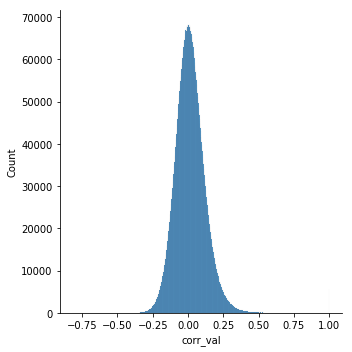

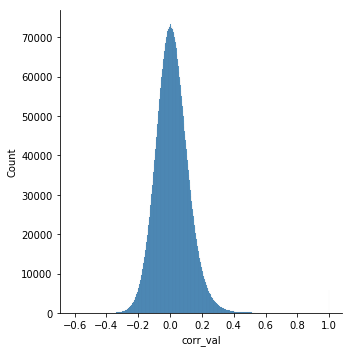

In [22]:
sns.displot(flat_pao1_corr_df["corr_val"])
sns.displot(flat_pa14_corr_df["corr_val"])

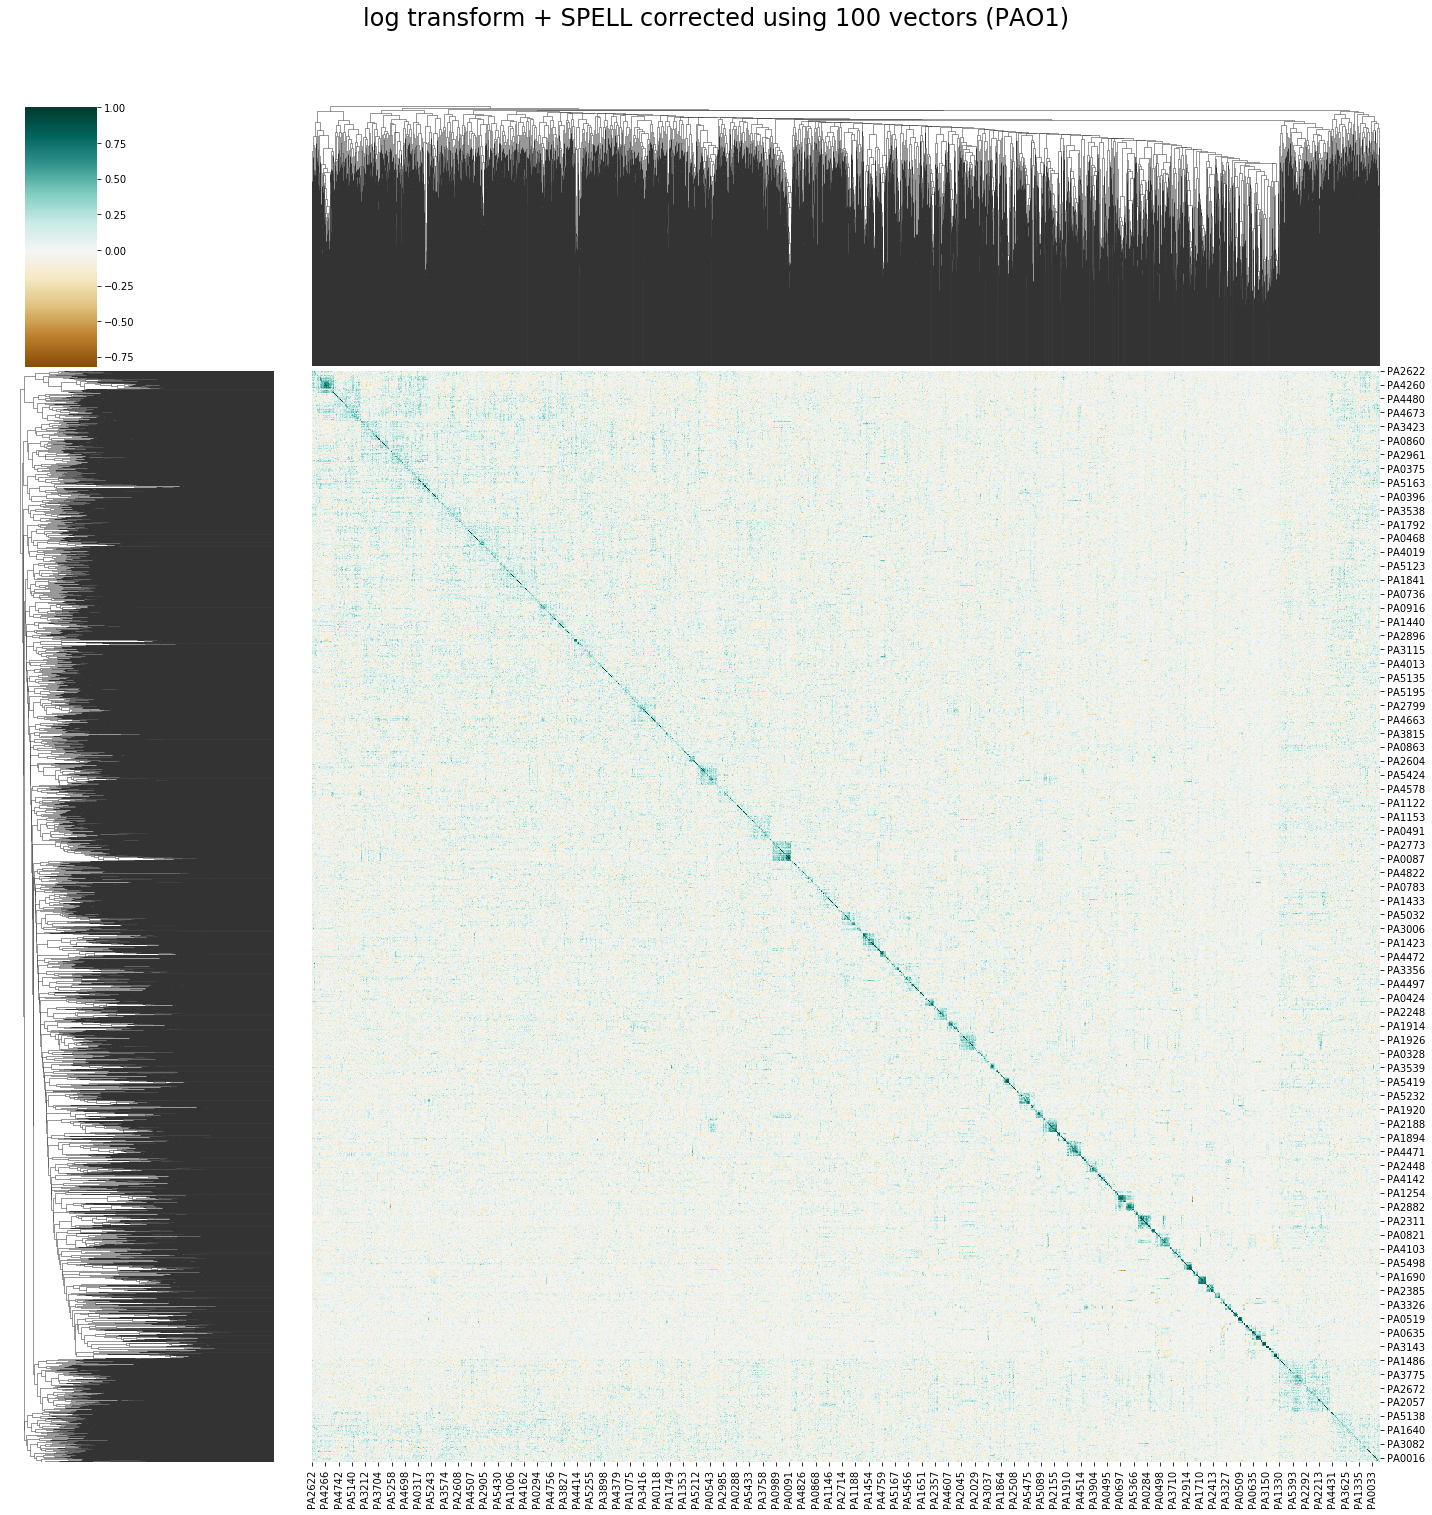

In [23]:
# Plot heatmap
h1a = sns.clustermap(pao1_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_SVs} vectors (PAO1)",
    y=1.05,
    fontsize=24,
)

# Save
pao1_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_log_spell_clustermap.png"
)
h1a.savefig(pao1_log_spell_filename, dpi=300)

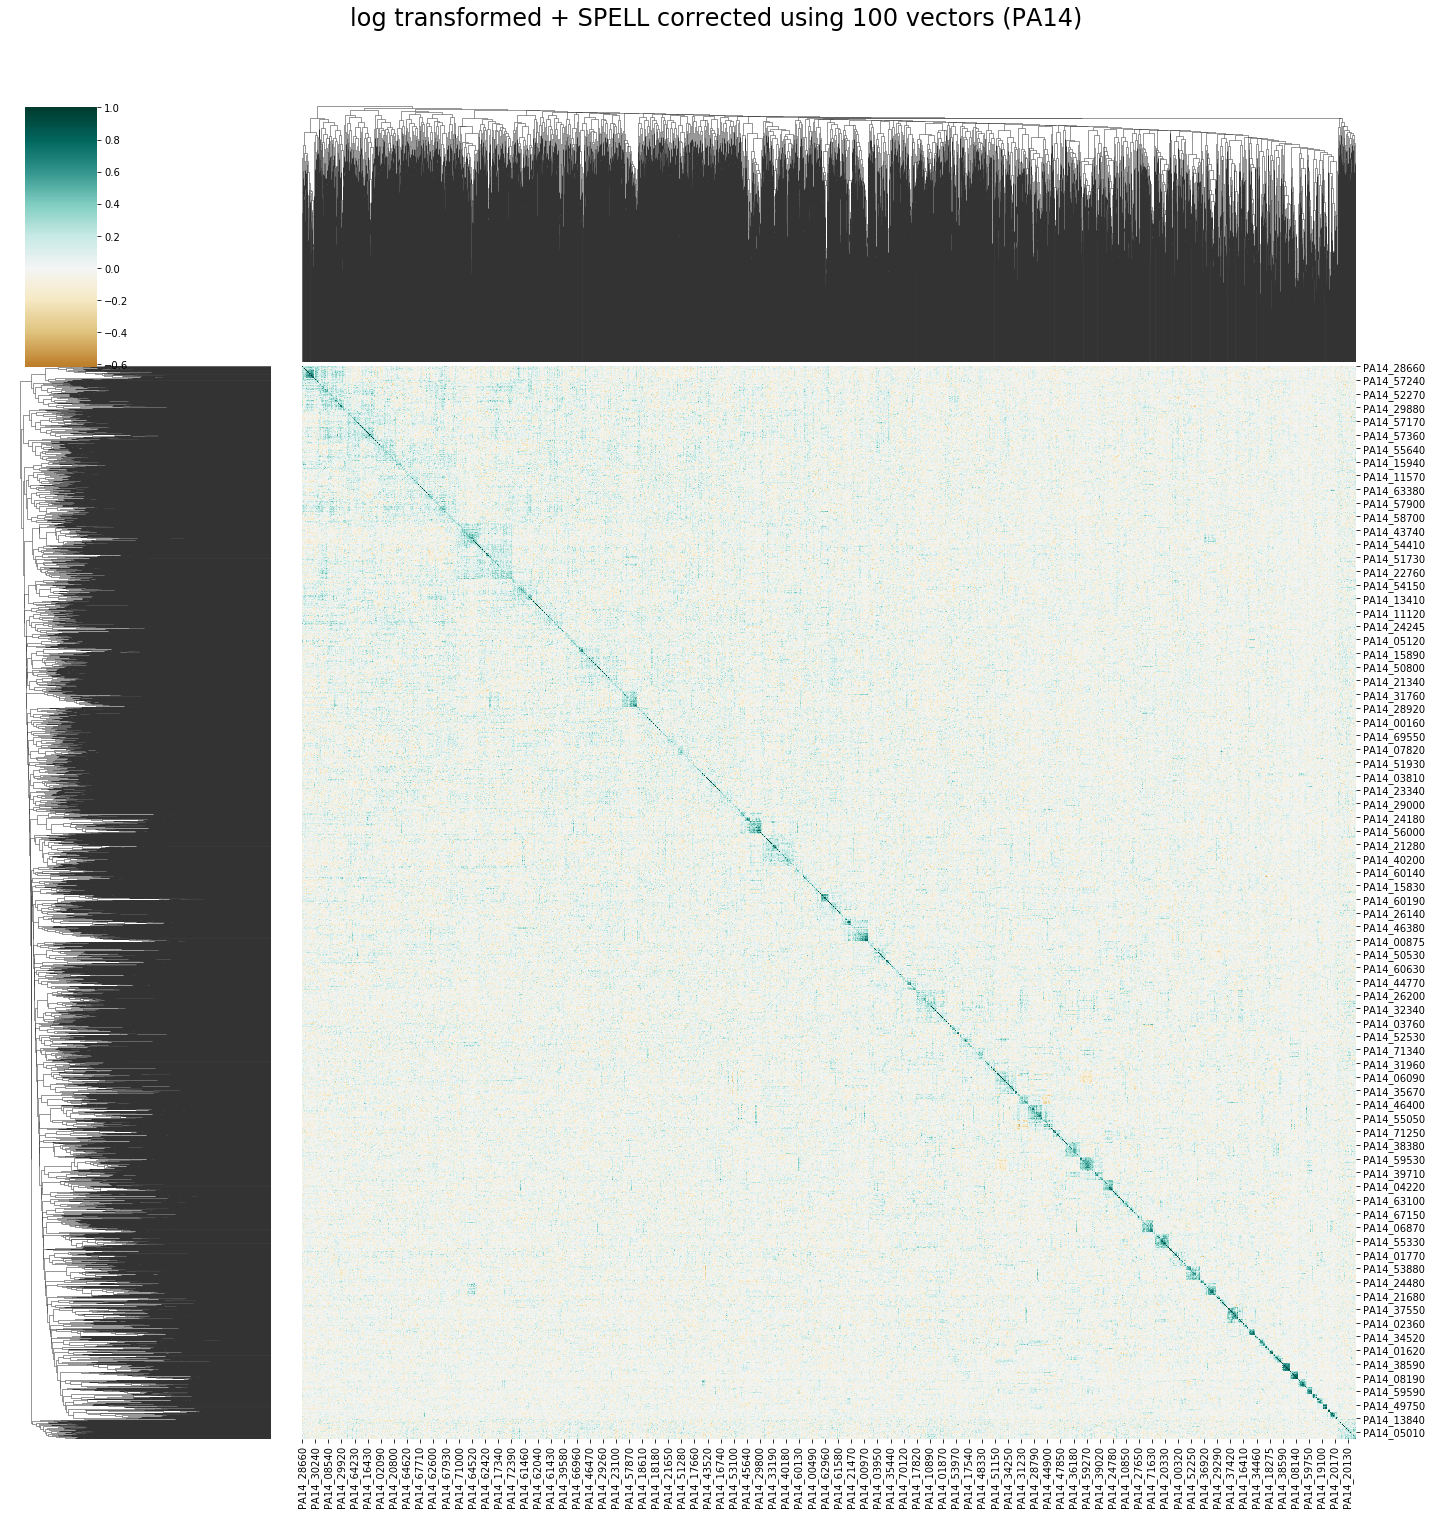

In [24]:
h2a = sns.clustermap(pa14_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h2a.fig.suptitle(
    f"log transformed + SPELL corrected using {num_SVs} vectors (PA14)",
    y=1.05,
    fontsize=24,
)

# Save
pa14_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_{subset_genes}_log_spell_clustermap.png"
)
h2a.savefig(pa14_log_spell_filename, dpi=300)

## Plot distribution of pairwise distances

This will particularly help to inform the parameters we use for DBSCAN, which is density based. Here we looking at the distribution of both global distances and local distances. Global distances are defined using `pdist`, which takes the pairwise Euclidean distance of each of the correlation vectors (so the distance between gene `p` and gene `q` is based on the difference in correlation between `p` and all other genes, and `q` and all other genes). Whereas the local distance is defined as 1 - |correlation(`p`, `q`)|

Text(0.5, 1.0, 'Distribution of pairwise distances for PAO1 genes')

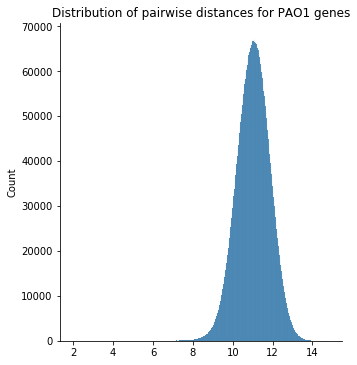

In [25]:
# Get distribution of pairwise distances to determine a cutoff defining what a dense region should be
f1 = sns.displot(pdist(pao1_corr_log_spell))
plt.title("Distribution of pairwise distances for PAO1 genes")

Text(0.5, 1.0, 'Distribution of pairwise distances for PA14 genes')

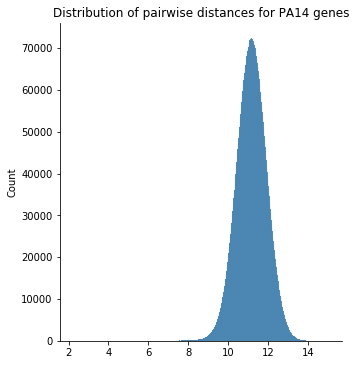

In [26]:
f2 = sns.displot(pdist(pa14_corr_log_spell))
plt.title("Distribution of pairwise distances for PA14 genes")

In [27]:
pao1_local_dist = 1 - pao1_corr_log_spell.abs()
pao1_local_dist = pao1_local_dist.where(
    np.triu(np.ones(pao1_local_dist.shape), k=1).astype(np.bool)
)
pao1_local_dist = pao1_local_dist.stack().reset_index()
pao1_local_dist.columns = ["Row", "Column", "Value"]

pao1_local_dist.head(10)

Row  Column     Value
0  PA0001  PA0002  0.473304
1  PA0001  PA0003  0.422623
2  PA0001  PA0004  0.600058
3  PA0001  PA0005  0.931576
4  PA0001  PA0006  0.822780
5  PA0001  PA0007  0.813228
6  PA0001  PA0008  0.761304
7  PA0001  PA0009  0.634954
8  PA0001  PA0010  0.946727
9  PA0001  PA0011  0.757675

Text(0.5, 1.0, 'Distribution of pairwise distances for PAO1 genes')

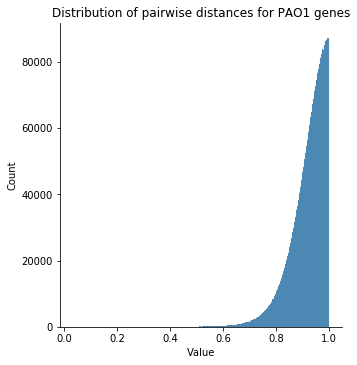

In [28]:
f3 = sns.displot(pao1_local_dist["Value"])
plt.title("Distribution of pairwise distances for PAO1 genes")

In [29]:
pa14_local_dist = 1 - pa14_corr_log_spell.abs()
pa14_local_dist = pa14_local_dist.where(
    np.triu(np.ones(pa14_local_dist.shape), k=1).astype(np.bool)
)
pa14_local_dist = pa14_local_dist.stack().reset_index()
pa14_local_dist.columns = ["Row", "Column", "Value"]

pa14_local_dist.head(10)

Row      Column     Value
0  PA14_55610  PA14_55600  0.450575
1  PA14_55610  PA14_55590  0.613015
2  PA14_55610  PA14_55580  0.879005
3  PA14_55610  PA14_55570  0.851035
4  PA14_55610  PA14_55560  0.910867
5  PA14_55610  PA14_55550  0.870178
6  PA14_55610  PA14_55540  0.955629
7  PA14_55610  PA14_55530  0.947597
8  PA14_55610  PA14_55520  0.941701
9  PA14_55610  PA14_55510  0.997495

Text(0.5, 1.0, 'Distribution of pairwise distances for PA14 genes')

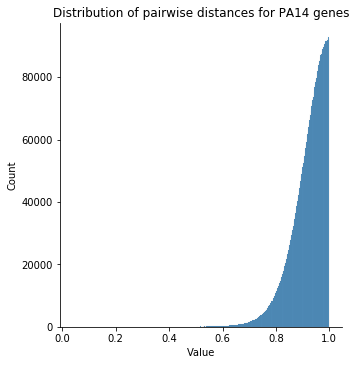

In [30]:
f4 = sns.displot(pa14_local_dist["Value"])
plt.title("Distribution of pairwise distances for PA14 genes")

In [ ]:
# Save log transform + SPELL correlation matrices
pao1_log_spell_mat_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_log_spell_mat.tsv"
)
pa14_log_spell_mat_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_{subset_genes}_log_spell_mat.tsv"
)
pao1_corr_log_spell.to_csv(pao1_log_spell_mat_filename, sep="\t")
pa14_corr_log_spell.to_csv(pa14_log_spell_mat_filename, sep="\t")